<a href="https://colab.research.google.com/github/Lynn1865/pydata-book/blob/1st-edition/Impact%20of%20remote%20work%20on%20stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier





## **Impact of Remote Work on Mental health: the dataset**

*   Dataset Name: "Impact of Remote Work on Mental Health
*   `[Kaggle Data Source](https://www.kaggle.com/datasets/waqi786/remote-work-and-mental-health)`
*   Target Variable: `Stress Level`

Dataset contains 19 features:
  * `Employee ID`
  * `Age`
  * `Gender`
  * `Job Role`(Categorical)
  * `Industry`(Categorical)
  * `Years of Experience`
  * `Work Location`(Categorical)
  * `Hours Worked per Week`
  * `Number of Virtual Meetings`
  * `Work Life Balance Rating`
  * `Stress Level`(Categorical)
  * `Mental Health Condition` (Categorical)
  * `Access to Mental Health Resources`(binary)
  * `Productivity Change`(Categorical)
  * `Social Isolation Rating`
  * `Satifaction with Remote Work`
  * `Company Support for Remote Work`
  * `Physical Activity`(Categorical)
  * `Sleep Quality`(Categorical)
  * `Region`(Categorical)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

health_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data files/Impact_of_Remote_Work_on_Mental_Health.csv')

display(health_df.head())
print("Data shape: ", health_df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America


Data shape:  (5000, 20)


In [4]:
# check for missing values

health_df.isnull().sum()

,0
Employee_ID,0
Age,0
Gender,0
Job_Role,0
Industry,0
Years_of_Experience,0
Work_Location,0
Hours_Worked_Per_Week,0
Number_of_Virtual_Meetings,0
Work_Life_Balance_Rating,0


Overall, the data is fairly clean with minimal issues. There are 1,196 null values in the mental health condition variable. Upon reviewing the data, "None" is an option within the evaluation system. The same applies to the physical activity variable with 1629 null values. The null values will be replaced with string "None".

In [5]:
# replace NaN with "None"
health_df['Mental_Health_Condition'] = health_df['Mental_Health_Condition'].replace(to_replace=np.nan, value="None")
health_df['Physical_Activity'] = health_df['Physical_Activity'].replace(to_replace= np.nan, value="None")

In [6]:
# dropping the column of employee ID
health_df = health_df.drop(columns=['Employee_ID'])

 ### **Exploratory Data Analysis**

In [7]:
# prompt: health_df.describe()

health_df.describe()


,Age,Years_of_Experience,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Social_Isolation_Rating,Company_Support_for_Remote_Work
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,40.995000,17.810200,39.614600,7.559000,2.984200,2.993800,3.007800
std,11.296021,10.020412,11.860194,4.636121,1.410513,1.394615,1.399046
min,22.000000,1.000000,20.000000,0.000000,1.000000,1.000000,1.000000
25%,31.000000,9.000000,29.000000,4.000000,2.000000,2.000000,2.000000
50%,41.000000,18.000000,40.000000,8.000000,3.000000,3.000000,3.000000
75%,51.000000,26.000000,50.000000,12.000000,4.000000,4.000000,4.000000
max,60.000000,35.000000,60.000000,15.000000,5.000000,5.000000,5.000000


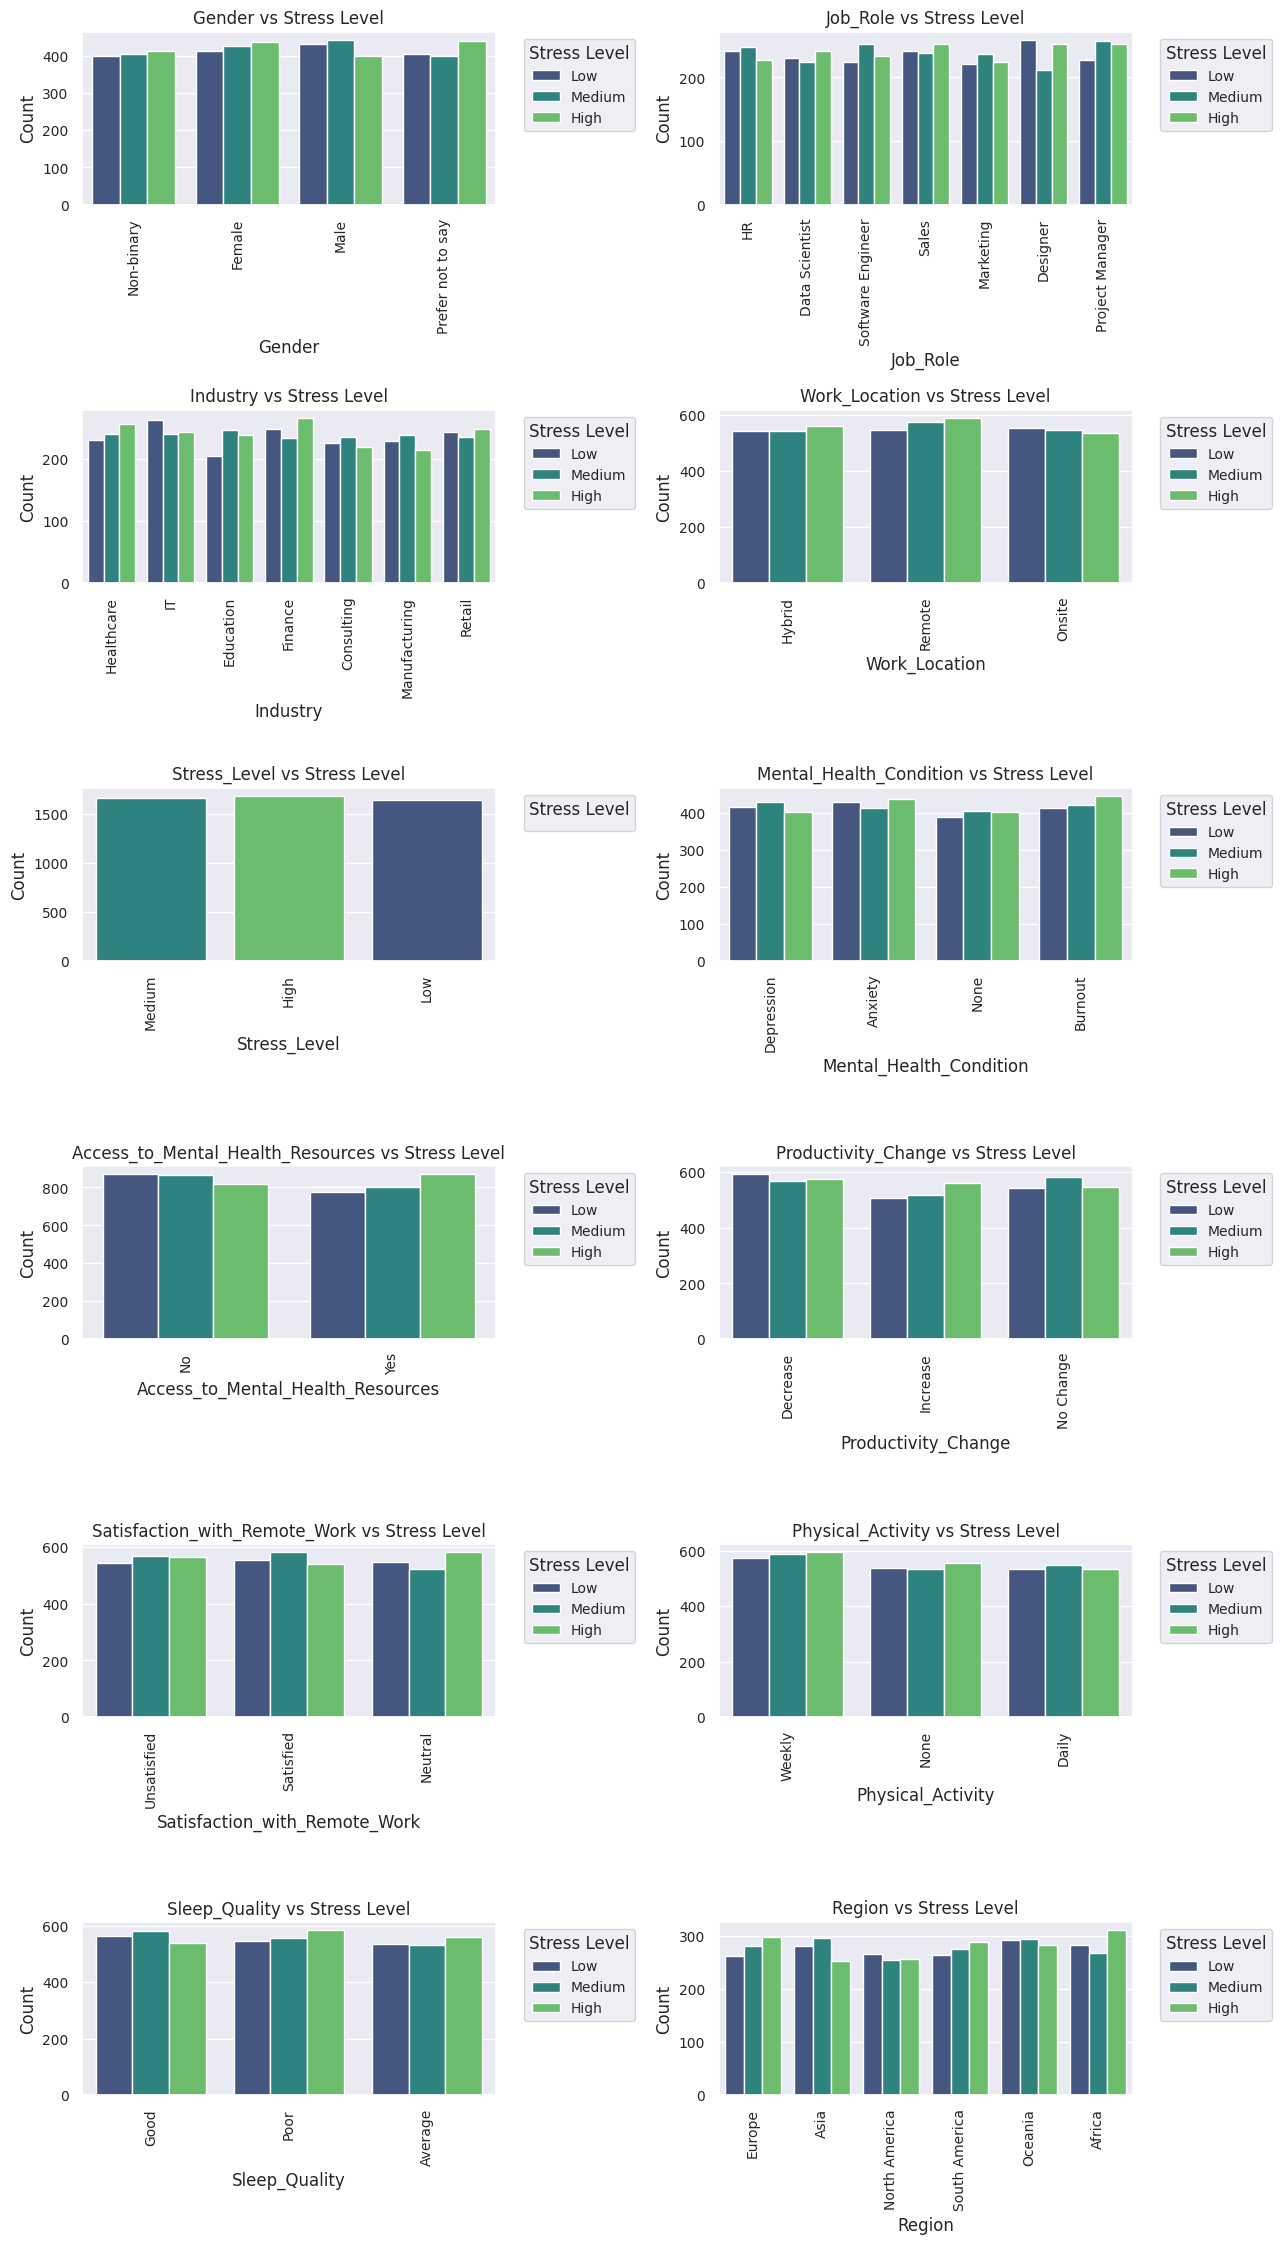

In [55]:
# More than half of the features are categorical variables. Set up the plotting space for all categorical variables
plt.figure(figsize=(13, 25))

# Loop through each categorical column and create a grouped bar chart with Stress Level

categorical_columns = health_df.select_dtypes(include=['object']).columns

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 2 + 1, 2, i)

    # Create a countplot for each categorical variable with Stress Level as hue
    order = ['Low', 'Medium', 'High']
    sns.countplot(data=health_df, x=column, hue='Stress_Level',hue_order=order,palette='viridis')



    # Set plot labels and title
    plt.title(f'{column} vs Stress Level')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90, fontsize=10)  # Adjust font size of x-tick labels
    plt.yticks(fontsize=10)
    plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

Observation:
* Product Manager appears to experience higher stress levels compared to other roles.
* Healthcare and education industry appears to have higher stress levels.
* Most features did not show a significant correlation with stress levels.

In [61]:
chi2_result = []
# Chi-Square test for each categorical predictor with Stress_Level

for column in categorical_columns:
    contingency_table = pd.crosstab(health_df[column], health_df['Stress_Level'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    chi2_result.append({'Feature': column, 'p-value': p})

# Convert the results to a DataFrame and print
chi_square_df = pd.DataFrame(chi2_result)
chi_square_df = chi_square_df.sort_values(by='p-value')
print("Chi-Square p-value between: ")
print("---------------------------------")
print(chi_square_df)

Chi-Square p-value between: 
---------------------------------
                              Feature   p-value
4                        Stress_Level  0.000000
6   Access_to_Mental_Health_Resources  0.026995
8       Satisfaction_with_Remote_Work  0.288981
7                 Productivity_Change  0.303792
11                             Region  0.413696
10                      Sleep_Quality  0.498967
0                              Gender  0.510168
1                            Job_Role  0.511532
2                            Industry  0.542918
3                       Work_Location  0.750048
5             Mental_Health_Condition  0.814279
9                   Physical_Activity  0.948874


Observation:
* Chi square test suggests that `Access to Mental Health Resources`has a significant relation with `Stress Level` due to its low p-value while `Satifaction with Remote Work` may be associated with `Stress Level`.

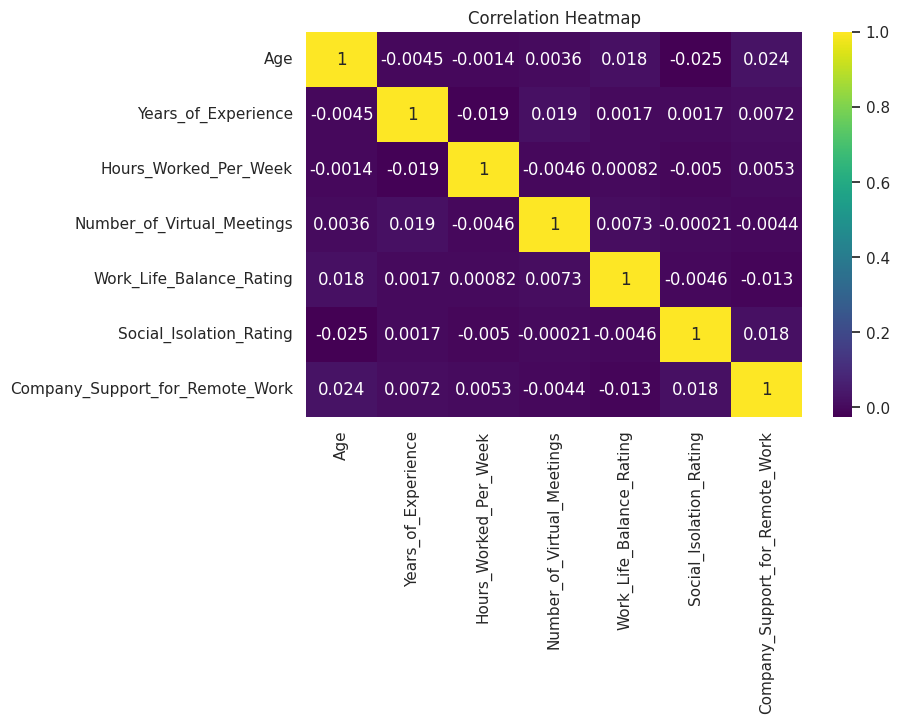

In [49]:
# heatmap
plt.figure(figsize=(8,5))

numeric_cols = health_df.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

Observation:
* The heatmap show minimal correlation between individual numerical features and `Stress_Level` with all correlation values below 0.03.  

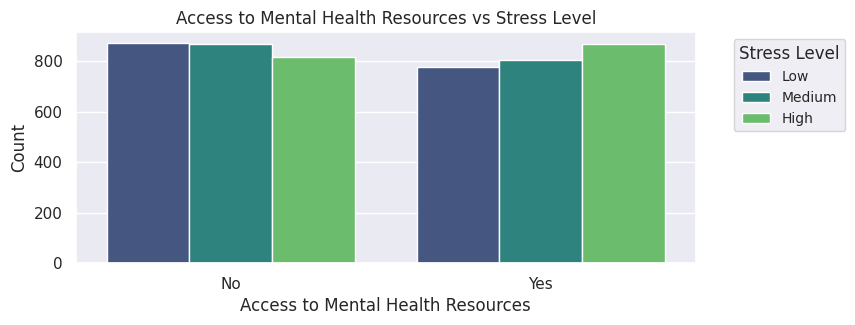

In [73]:
stress_counts = health_df.pivot_table(index='Access_to_Mental_Health_Resources', columns='Stress_Level', aggfunc='size', fill_value=0)

# Plot as heatmap
plt.figure(figsize=(8, 3))
sns.countplot(data=health_df, x='Access_to_Mental_Health_Resources', hue='Stress_Level', hue_order=order,palette='viridis')
plt.title('Access to Mental Health Resources vs Stress Level')
plt.xlabel('Access to Mental Health Resources')
plt.ylabel('Count')
plt.legend(title='Stress Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()


##  **Decision Tree Model**


In [11]:
# create a copy to prevent lost data
df = health_df.copy()

X = df.drop(columns=['Stress_Level'])
y = df['Stress_Level']

# Convert all categorical variables to numerical format using one-hot encoding
X = pd.get_dummies(X, drop_first=True)
# Encode the target variable because it is categorical
y = y.astype('category').cat.codes

# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=8)

# fittng the model with training data
tree.fit(X_train, y_train)

# making predictions
y_pred = tree.predict(X_test)

In [17]:
# Evaluate the model

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# f1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score(macro):", round(f1,3))


Accuracy: 0.352
F1 Score(macro): 0.35


## **Gradient Descent Model - XGBoost**

In [21]:
xgb_model = XGBClassifier(max_depth=8, n_estimators=100, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost F1 Score (macro):", f1_xgb)


XGBoost Accuracy: 0.354
XGBoost F1 Score (macro): 0.3540701730761946


In [25]:
# Get feature importances from XGBoost
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)
sorted_feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)

# Display top features
print("Features rated by importance (XGBoost):\n", sorted_feature_importances_xgb.head(20))

Features rated by importance (XGBoost):
 Industry_Education                         0.030160
Job_Role_Project Manager                   0.030046
Job_Role_Marketing                         0.029706
Industry_Finance                           0.029347
Job_Role_Software Engineer                 0.029056
Industry_IT                                0.027194
Region_South America                       0.027191
Industry_Healthcare                        0.026888
Job_Role_Sales                             0.026619
Job_Role_Designer                          0.026399
Industry_Retail                            0.026267
Industry_Manufacturing                     0.025889
Region_Oceania                             0.025507
Gender_Non-binary                          0.025285
Mental_Health_Condition_Burnout            0.025170
Region_Asia                                0.024476
Number_of_Virtual_Meetings                 0.024233
Region_Europe                              0.024183
Satisfaction_with_Remot